In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random, os

import tensorflow as tf

In [13]:
mnist = tf.keras.datasets.mnist

In [14]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [21]:
X_train = tf.keras.utils.normalize(X_train, axis=1)
X_test = tf.keras.utils.normalize(X_test, axis=1)

model = tf.keras.models.Sequential() #Two kinds of models, Sequential being the easy one
model.add(tf.keras.layers.Flatten()) #Want this to be a layer, because at the end of a CNN there can be a very convoluted end-layer
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu)) #activation makes the neuron fire, relu=redvilinear?
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax)) #softmax for probability distribution

# Check for Gradient Descent (stochastic?)

model.compile(optimizer="adam",
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

In [22]:
model.fit(X_train, y_train, epochs=5)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8656 - loss: 0.4757
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9652 - loss: 0.1143
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9765 - loss: 0.0755
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9825 - loss: 0.0561
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9858 - loss: 0.0434


In [24]:
val_loss, val_acc = model.evaluate(X_test, y_test)
print(val_loss, val_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9632 - loss: 0.1266
0.10905644297599792 0.9690999984741211


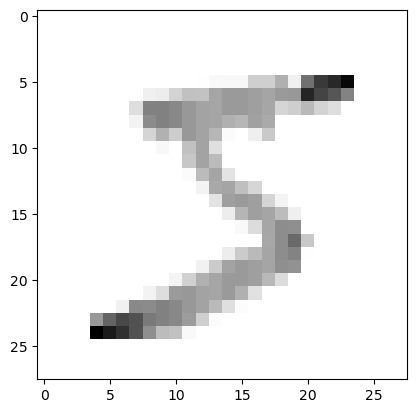

In [20]:
plt.imshow(X_train[0], cmap=plt.cm.binary)
plt.show()

In [28]:
predictions = model.predict([X_test])

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [34]:
np.argmax(predictions[1])

2

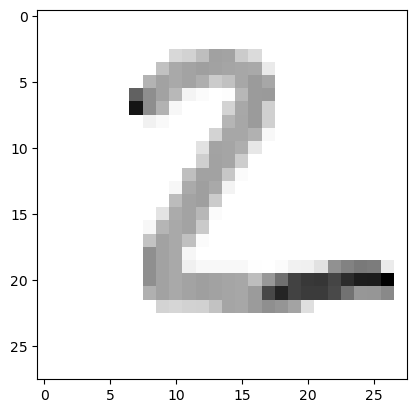

In [35]:
plt.imshow(X_test[1], cmap=plt.cm.binary)
plt.show()